<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/distributionSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import seaborn as sns

from scipy.stats import alpha, gamma, lognorm, skewnorm, weibull_min
from scipy.optimize import curve_fit
from functools import partial
from sklearn.metrics import r2_score

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
warnings.filterwarnings('ignore') #Disable warning

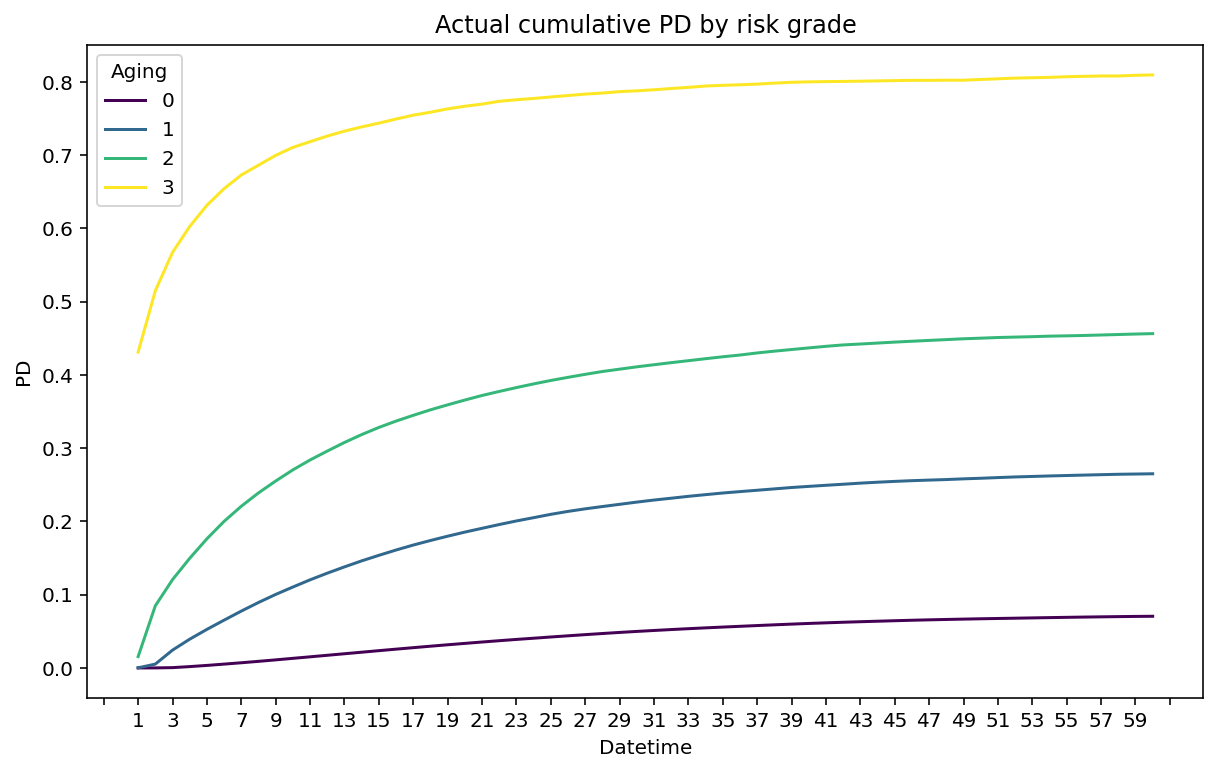

In [ ]:
# Import dataset
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/PDRiskGrade.csv'
)

# Select one (CU) segment for example
df = df.query(
    "Segment == 'CU'"
).drop(
    ['Segment'],
    axis = 1
).set_index(
    ['Aging']
)

# Plot
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
    x = 'times',
    y = 'PD',
    data = pd.melt(
        df.iloc[:, 1:].reset_index().rename(
            columns = {'index': 'Aging'}
        ),
        id_vars = ['Aging'],
        var_name = 'times',
        value_name = 'PD'
    ),
    hue = 'Aging',
    legend = 'full',
    palette = 'viridis',
    ci = None
)
ax.set_title('Actual cumulative PD by risk grade')
ax.set(xlabel = 'Datetime', ylabel = 'PD')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

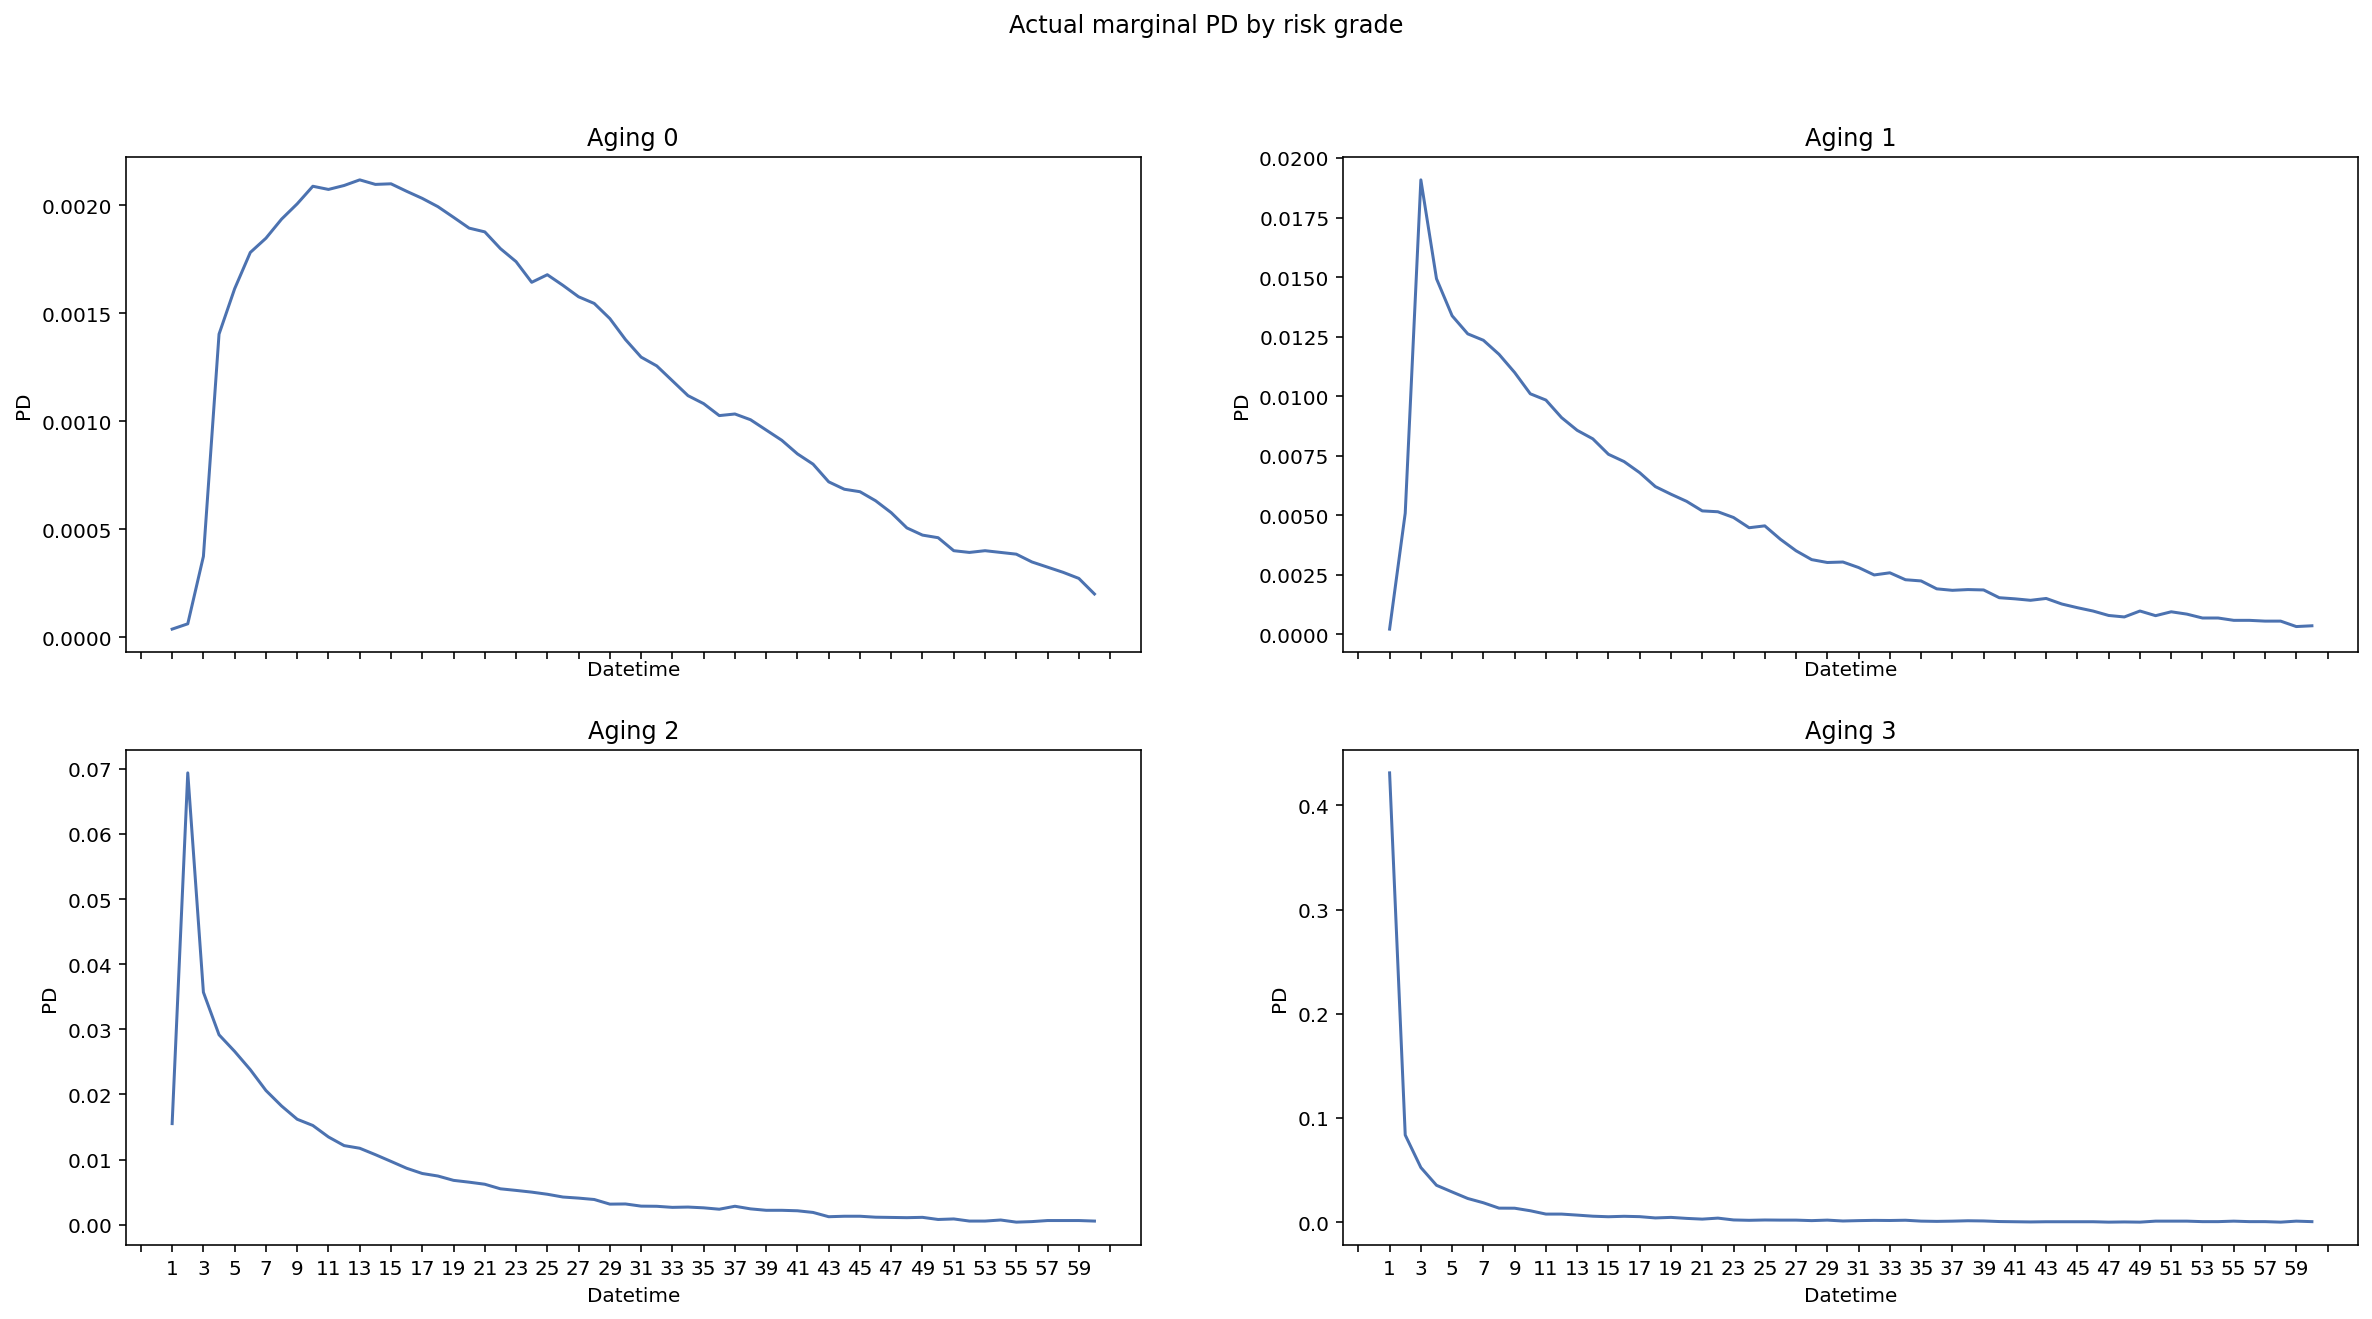

In [ ]:
# Calculate marginal PD
dfMar = df.iloc[:, 1:].diff(1, axis = 1)
dfMar.iloc[:, 0] = df.iloc[:, 1]

# Plot
fig, axs = plt.subplots(
    2, 2,
    figsize = (20, 10),
    sharex = True
)
fig.suptitle('Actual marginal PD by risk grade')
axs = axs.ravel()
for i in dfMar.index:
  dataPlot = dfMar.iloc[i]
  axs[i].plot(
      dfMar.iloc[i]
  )
  axs[i].set_title(f'Aging {i}')
  axs[i].set(xlabel = 'Datetime', ylabel = 'PD')
  axs[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

In [ ]:
# Define distribution function
# chi2, gamma, lognorm, skewnorm, weibull
# Each distribution need adjustment factor
def alphaFitting(x, est, s, adj):
  return alpha.pdf(x, est, loc = 0, scale = s) * adj

def gammaFitting(x, est, s, adj):
  return gamma.pdf(x, est, loc = 0, scale = s) * adj

def lognormFitting(x, est, s, adj):
  return lognorm.pdf(x, est, loc = 0, scale = s) * adj

def skenormFitting(x, est, s, adj):
  return skewnorm.pdf(x, est, loc = 0, scale = s) * adj

def weibullFitting(x, est, s, adj):
  return weibull_min.pdf(x, est, loc = 0, scale = s) * adj

In [ ]:
# Distribution
distribution = ['alpha', 'gamma', 'lognorm', 'skewnorm', 'weibull']
colors = np.random.choice(
    list(mcolors.TABLEAU_COLORS.keys()),
    len(distribution)
)

# Define Fitter function
def Fitter(data, distribution, plot = None):
  TEST = []
  fig, axs = plt.subplots(2, 2, figsize = (20, 10), sharex = True)
  fig.suptitle('Comparison distribution fitting')
  axs = axs.ravel()
  for i in data.index:
    test = []
    odr = data.iloc[i]
    times = np.arange(1, odr.shape[0] + 1)
    # Plot actual
    axs[i].plot(
        odr,
        c = 'gray',
        linestyle = '--',
        label = 'Actual'
    )
    axs[i].set_title(f'Aging {i}')
    axs[i].set(xlabel = 'Datetime', ylabel = 'PD')
    for dist, color in zip(distribution, colors):
      if dist == 'alpha':
        method = partial(alphaFitting)
      if dist == 'gamma':
        method = partial(gammaFitting)
      if dist == 'lognorm':
        method = partial(lognormFitting)
      if dist == 'skewnorm':
        method = partial(skenormFitting)
      if dist == 'weibull':
        method = partial(weibullFitting)
      # Fitting with distribution
      popt, _ = curve_fit(
          method,
          times,
          odr,
          [1, 1, 1],
          maxfev = 100000
      )
      fittedODR = [method(x, *popt) for x in times] #Fitting result
      sse = np.sum((odr - fittedODR) ** 2) #SSE
      r2 = r2_score(odr, fittedODR) #R-Square
      test.append([i, dist, sse, r2])
      # Plot fitted
      axs[i].plot(
          fittedODR,
          c = color,
          linewidth = 2.5,
          label = dist,
          alpha = 0.5
      )
      axs[i].legend(frameon = True, facecolor = 'white')
      axs[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    TEST.extend(test)
  # DataFrame
  TESTResult = pd.DataFrame(
      TEST,
      columns = ['Aging', 'Distribution', 'SSE', 'R-Square']
  ).round(4)
  return TESTResult, plt.show()

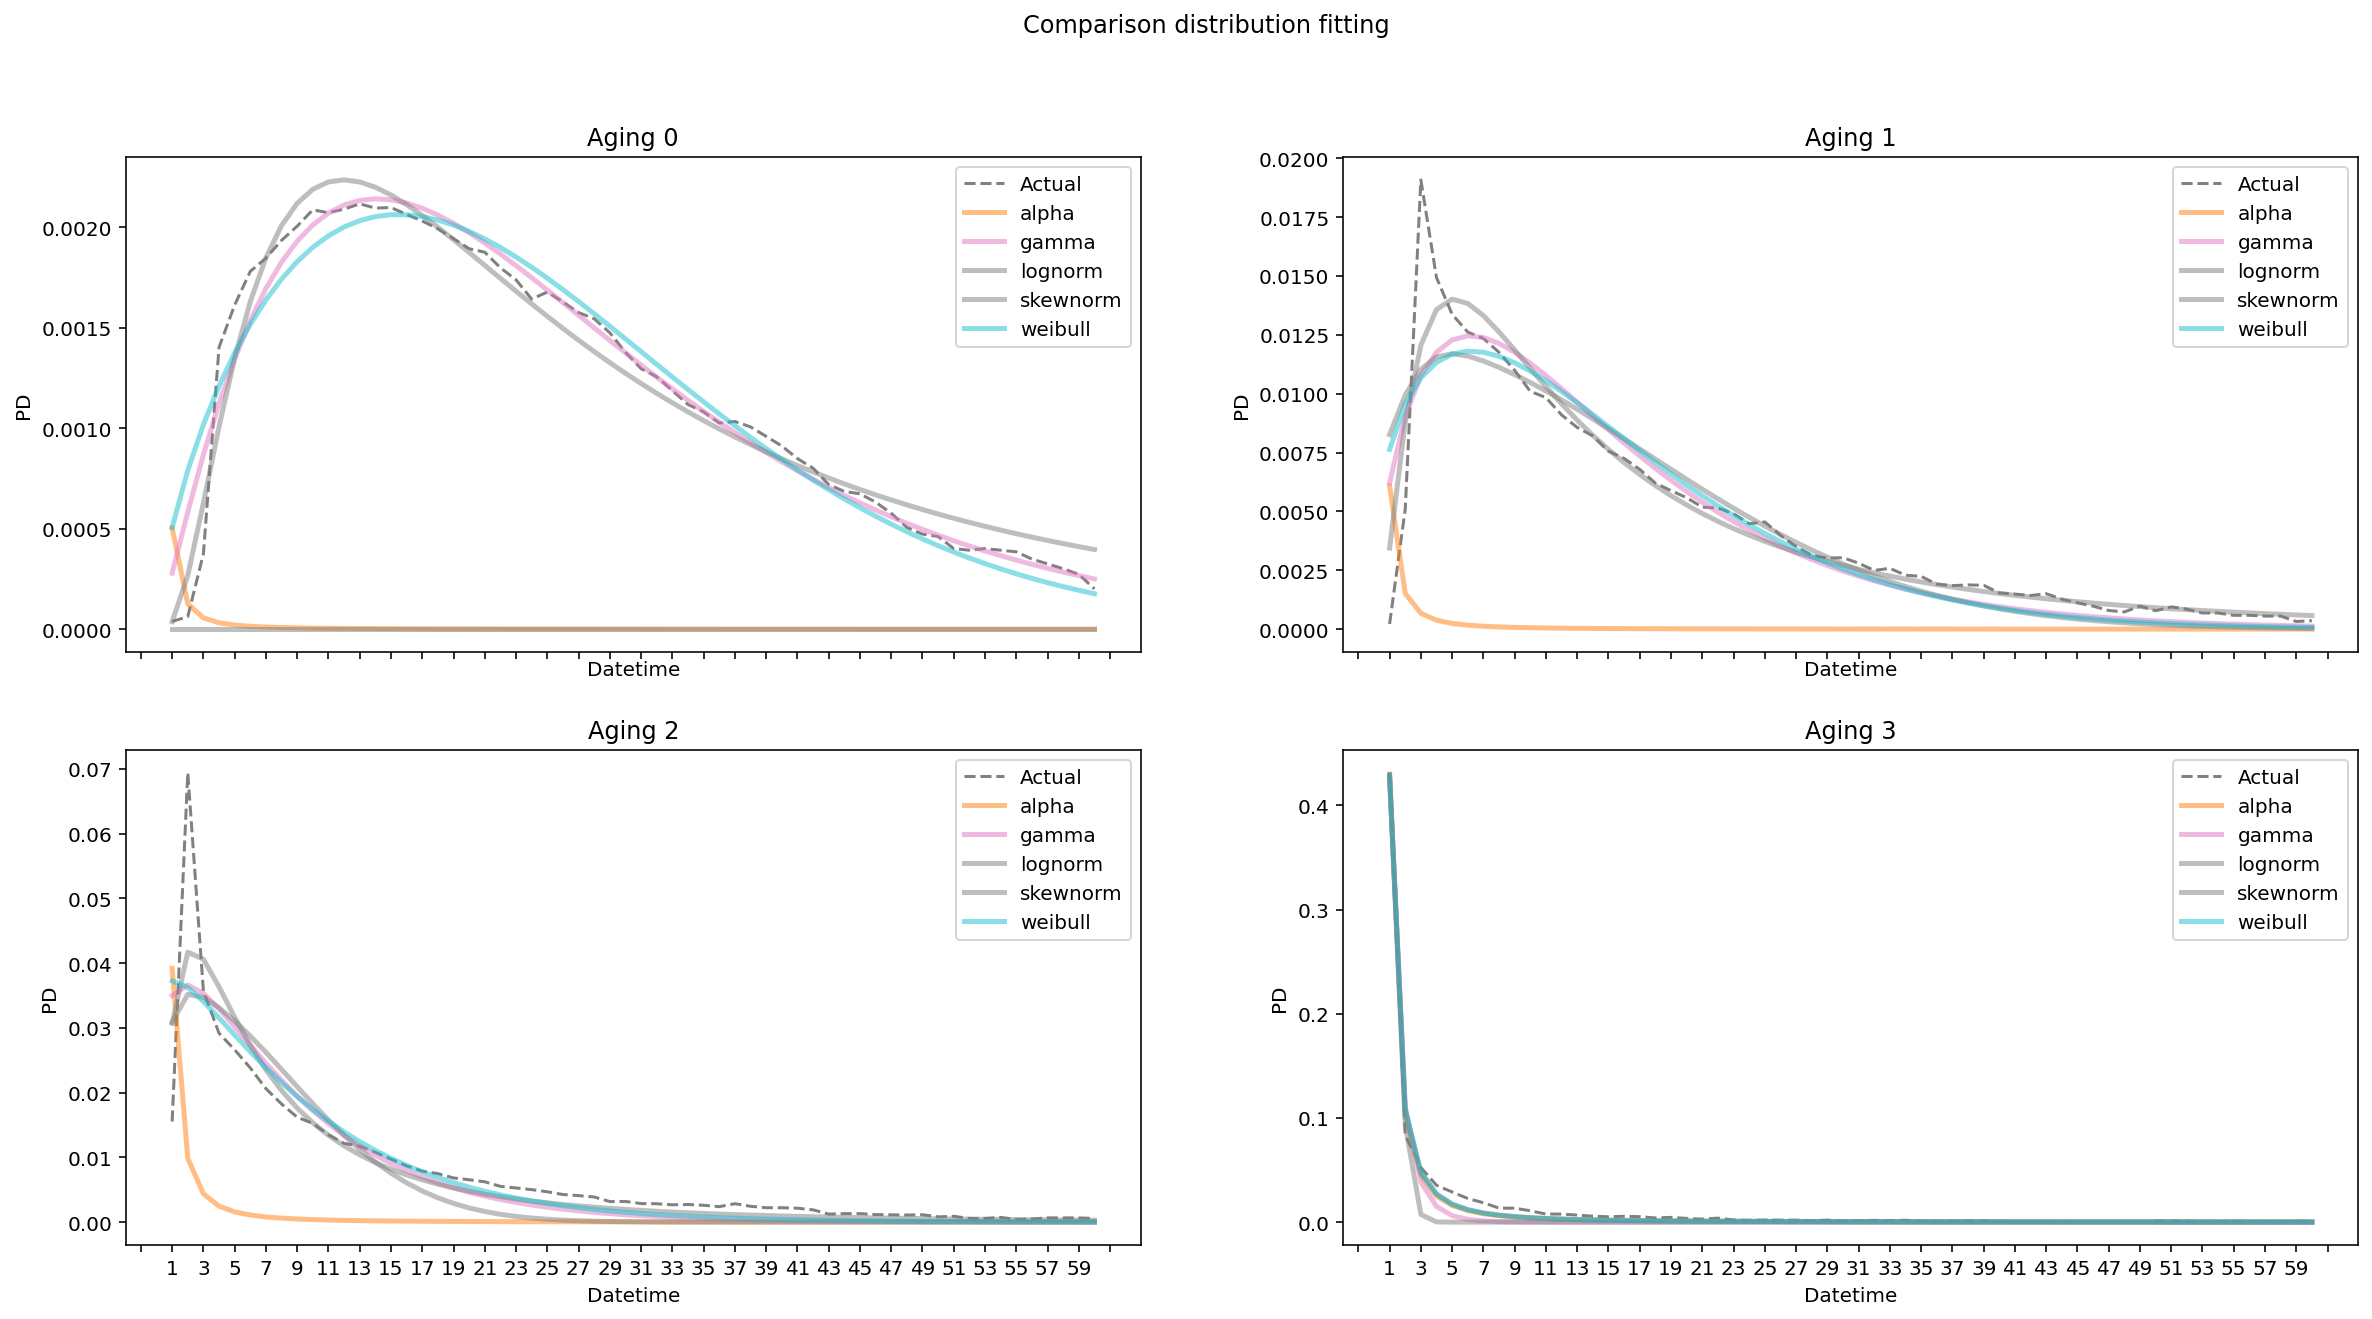

In [ ]:
# Apply function
fittedResult, _ = Fitter(dfMar, distribution)

In [ ]:
# Fitted results
fittedResult['RankSSE'] = fittedResult.groupby(
    ['Aging']
)['SSE'].rank(
    method = 'first', ascending = True
)

fittedResult['RankR2'] =  fittedResult.groupby(
    ['Aging']
)['R-Square'].rank(
    method = 'first',
    ascending = False
)

fittedResult

,Aging,Distribution,SSE,R-Square,RankSSE,RankR2
0,0,alpha,0.0001,-3.1297,4.0,4.0
1,0,gamma,0.0000,0.9649,1.0,2.0
2,0,lognorm,0.0000,0.9680,2.0,1.0
3,0,skewnorm,0.0001,-3.1401,5.0,5.0
4,0,weibull,0.0000,0.9352,3.0,3.0
5,1,alpha,0.0022,-1.0169,5.0,5.0
6,1,gamma,0.0002,0.8645,2.0,2.0
7,1,lognorm,0.0001,0.9242,1.0,1.0
8,1,skewnorm,0.0002,0.8306,3.0,4.0
9,1,weibull,0.0002,0.8363,4.0,3.0


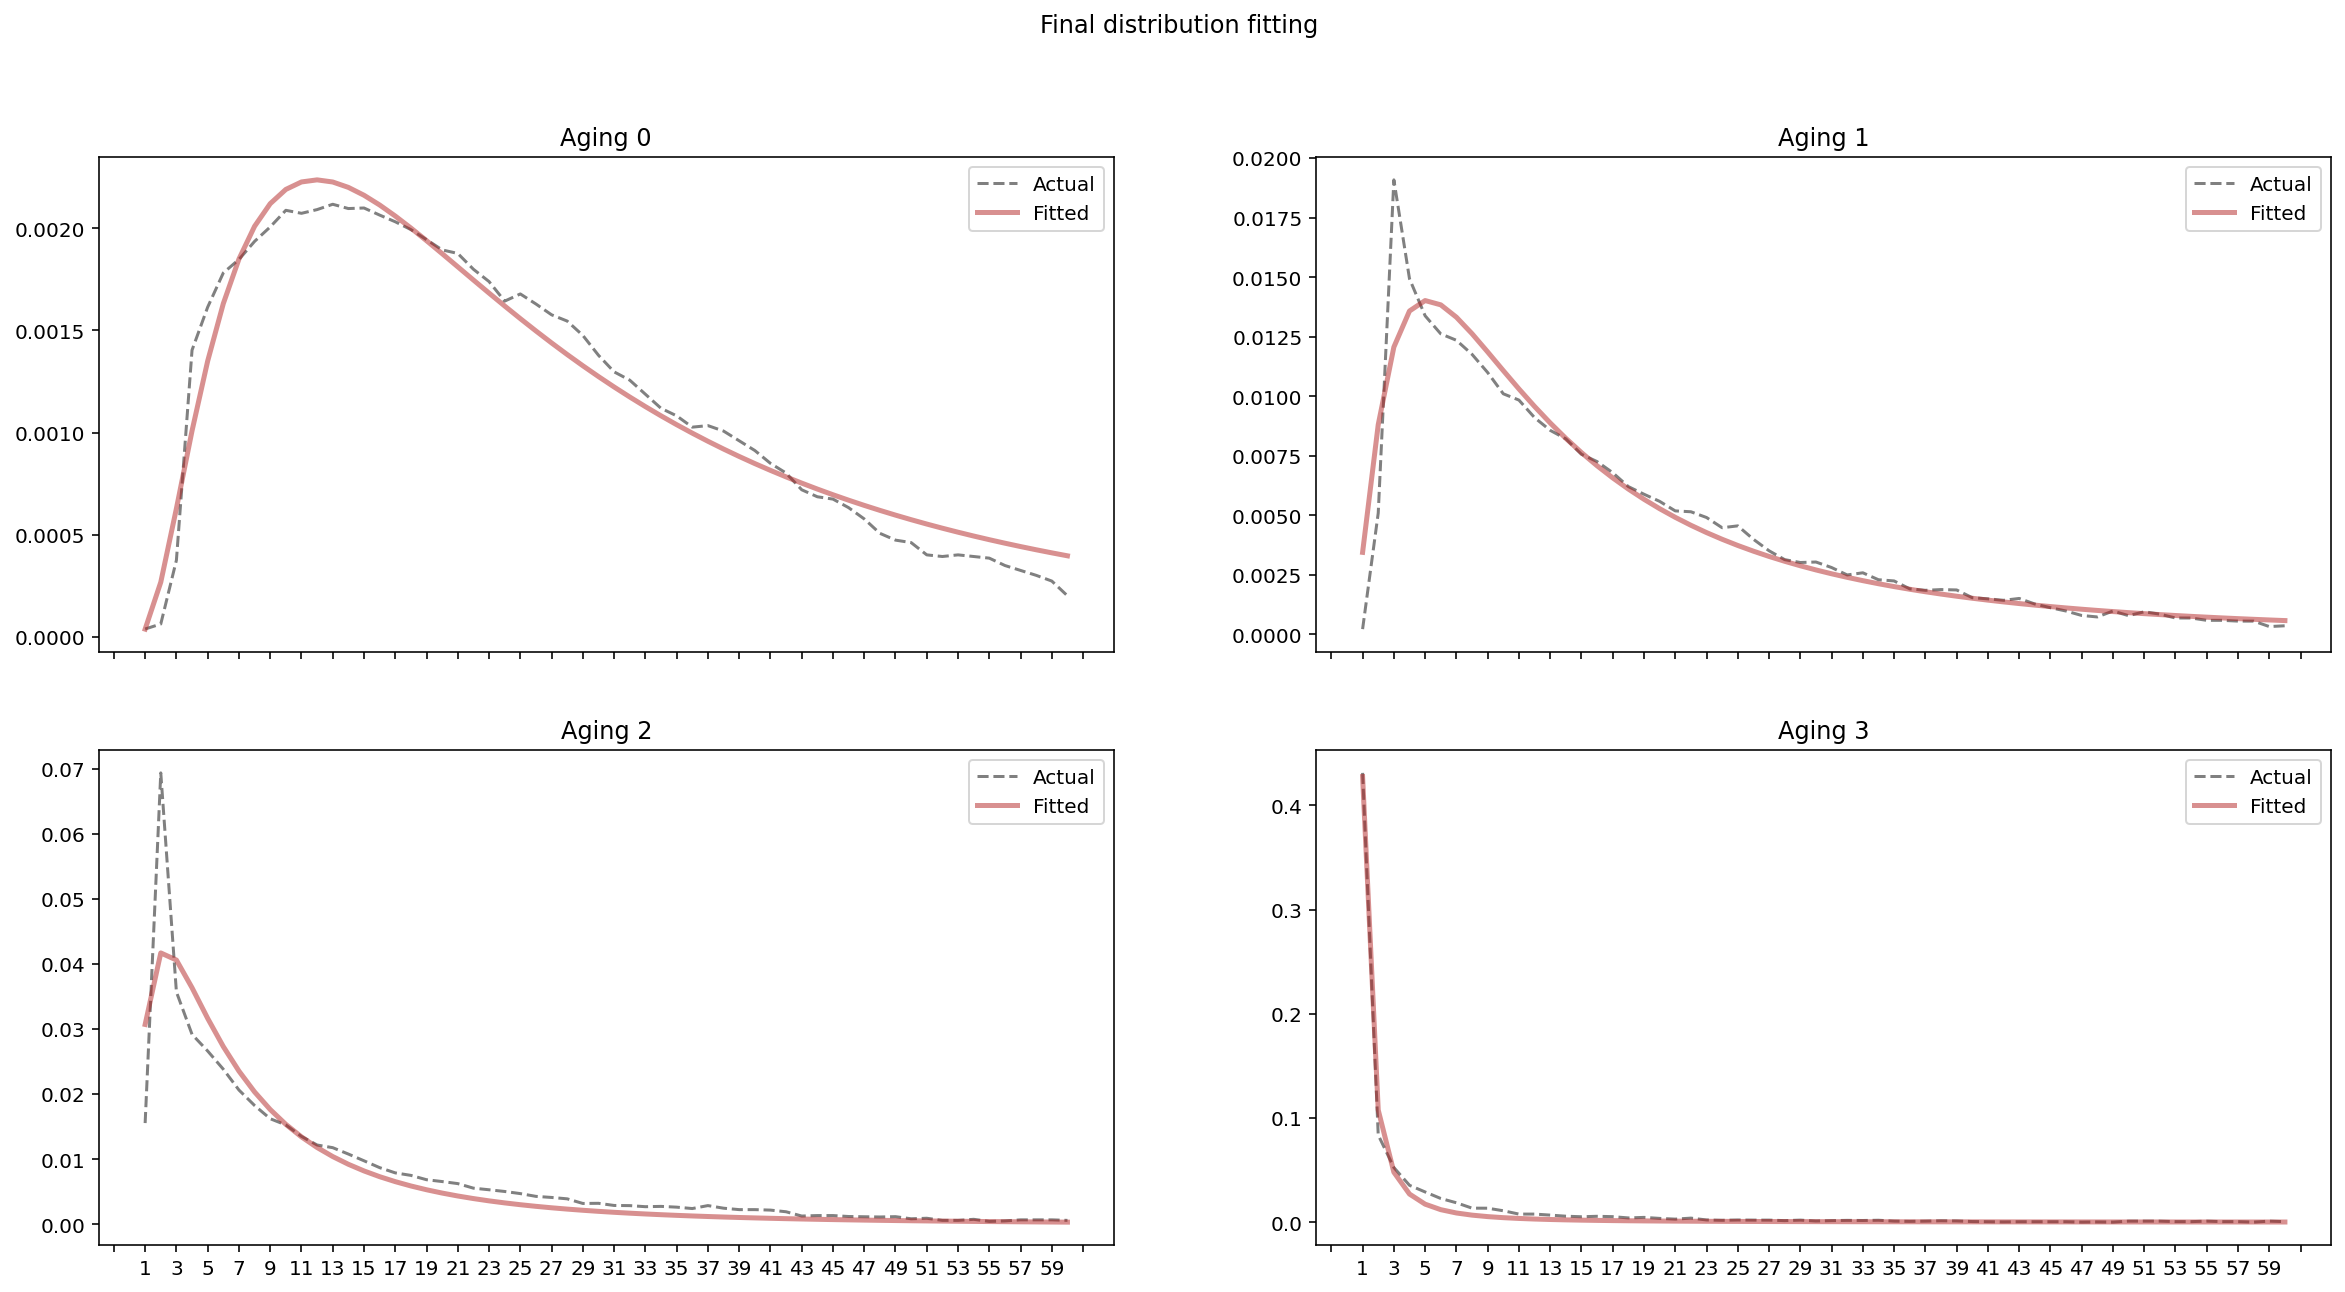

In [ ]:
# Select 'lognorm' distribution for fitting
fig, axs = plt.subplots(2, 2, figsize = (20, 10), sharex = True)
fig.suptitle('Final distribution fitting')
axs = axs.ravel()
for i in dfMar.index:
  odr = dfMar.iloc[i]
  times = np.arange(1, odr.shape[0] + 1)
  popt, _ = curve_fit(
      lognormFitting,
      times,
      odr,
      [1, 1, 1],
      maxfev = 100000
  )
  fittedODR = [lognormFitting(x, *popt) for x in times]
  # Plot
  axs[i].plot(
      odr,
      c = 'gray',
      linestyle = '--',
      label = 'Actual'
  )
  axs[i].plot(
      fittedODR,
      c = 'firebrick',
      linewidth = 2.5,
      label = 'Fitted',
      alpha = 0.5
  )
  axs[i].set_title(f'Aging {i}')
  axs[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
  axs[i].legend(frameon = True, facecolor = 'white')
plt.show()